In [50]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from system_dynamics import Sys_dynamics

In [51]:
sys_dynamics = Sys_dynamics() # instantiation

# training data    
num_data = 2000

u_b = 15*np.pi/180

n_state = 3
n_control = 1
dt = 0.001
n_nn = 10


x_b1 = 15*np.pi/180
x_b2 = 90*np.pi/180


uc_rand = np.random.uniform(-u_b,u_b,(num_data,n_control))
x1_rand = np.random.uniform(-x_b1,x_b1,(num_data,1))
x2_rand = np.random.uniform(-x_b2,x_b2,(num_data,1))
x3_rand = np.random.uniform(-u_b,u_b,(num_data,1))


x_rand = np.concatenate((x1_rand,x2_rand,x3_rand),axis = 1)
m_input_rand = np.concatenate((x_rand,uc_rand), axis= 1)


x_next_rand = np.zeros((num_data,n_state))


for i in range(num_data):
    uc = uc_rand[i]
    x_in = x_rand[i]
    x_next_rand[i,:]= sys_dynamics.launch_vehicle(x_in,uc,dt)


print(m_input_rand.shape, '\n\n', x_next_rand.shape)
print(m_input_rand[0])

(2000, 4) 

 (2000, 3)
[-0.00199723  0.44906654 -0.02280355  0.08827644]


In [52]:
class Model(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.linear1 = torch.nn.Linear(n_input, n_hidden, bias=False)
        self.linear2 = torch.nn.Linear(n_hidden, n_hidden, bias=False)
        self.linear3 = torch.nn.Linear(n_hidden, n_output, bias=False)

        # self.linear1.weight.data.uniform_(-0.5, 0.5)   # initialization
        # self.linear2.weight.data.uniform_(-0.5, 0.5)   # initialization
        # self.linear3.weight.data.uniform_(-0.5, 0.5)   # initialization
    def forward(self, x):
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        x = torch.tanh(x)
        output = self.linear3(x)
        return output


model = Model(n_input=n_state+n_control, n_hidden=n_nn, n_output=n_state)

In [53]:

# training
learning_rate = 1e-2
num_epochs = 1000

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


# data feed one by one
def train_loop(x_input, x_next_label, model, loss_fn, optimizer):
    for i in range(num_data):
        x = torch.tensor(x_input[i], dtype=torch.float32)
        y = torch.tensor(x_next_label[i], dtype=torch.float32)
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('loss:', loss.item())


# batch training (data size as batch size)
def train_loop_batch(x_input, x_next_label, model, loss_fn, optimizer, epoch):
    x = torch.tensor(x_input, dtype=torch.float32)
    y = torch.tensor(x_next_label, dtype=torch.float32)
    # Compute prediction and loss
    pred = model(x)
    loss = loss_fn(pred, y)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('loss:', loss.item(),'epoch:', epoch)

# training loop
for epoch in range(num_epochs):
    train_loop_batch(m_input_rand, x_next_rand, model, loss_fn, optimizer,epoch)



loss: 0.29053640365600586 epoch: 0
loss: 0.2686019539833069 epoch: 1
loss: 0.24708038568496704 epoch: 2
loss: 0.22546754777431488 epoch: 3
loss: 0.20359700918197632 epoch: 4
loss: 0.18144065141677856 epoch: 5
loss: 0.159099280834198 epoch: 6
loss: 0.13683390617370605 epoch: 7
loss: 0.11507850885391235 epoch: 8
loss: 0.09439888596534729 epoch: 9
loss: 0.07534334063529968 epoch: 10
loss: 0.05824779346585274 epoch: 11
loss: 0.04329767823219299 epoch: 12
loss: 0.030841436237096786 epoch: 13
loss: 0.02142428420484066 epoch: 14
loss: 0.015568528324365616 epoch: 15
loss: 0.013472524471580982 epoch: 16
loss: 0.014779721386730671 epoch: 17
loss: 0.01860286295413971 epoch: 18
loss: 0.02359653264284134 epoch: 19
loss: 0.028144830837845802 epoch: 20
loss: 0.030861465260386467 epoch: 21
loss: 0.031130991876125336 epoch: 22
loss: 0.029196111485362053 epoch: 23
loss: 0.02578176185488701 epoch: 24
loss: 0.02168872579932213 epoch: 25
loss: 0.017583277076482773 epoch: 26
loss: 0.013965342193841934 epoch

In [54]:

# Testing
num_data = 500 # for test
uc_rand = np.random.uniform(-u_b,u_b,(num_data,n_control))
x1_rand = np.random.uniform(-x_b1,x_b1,(num_data,1))
x2_rand = np.random.uniform(-x_b2,x_b2,(num_data,1))
x3_rand = np.random.uniform(-u_b,u_b,(num_data,1))


x_rand = np.concatenate((x1_rand,x2_rand,x3_rand),axis = 1)
m_input_rand = np.concatenate((x_rand,uc_rand), axis= 1)


x_next_rand = np.zeros((num_data,n_state))


for i in range(num_data):
    uc = uc_rand[i]
    x_in = x_rand[i]
    x_next_rand[i,:]= sys_dynamics.launch_vehicle(x_in,uc,dt)


m_input_tensor = torch.tensor(m_input_rand, dtype=torch.float32)
x_next_pred = model(m_input_tensor).detach().numpy()
print('test x_next_label: \n', x_next_rand[:5])
print('x_next prediction: \n', x_next_pred[:5])


test x_next_label: 
 [[-0.01340305 -1.31695388  0.10684999]
 [ 0.01220965  1.49301355 -0.08153664]
 [-0.18066522 -1.45528019 -0.16010119]
 [ 0.07639404 -0.48399309 -0.13375381]
 [-0.08416279  1.39237764  0.11674397]]
x_next prediction: 
 [[-0.0110148  -1.3178105   0.10657389]
 [ 0.00774652  1.4742196  -0.08135112]
 [-0.16451596 -1.4165266  -0.14881478]
 [ 0.07933734 -0.5014997  -0.13922307]
 [-0.08361611  1.3806221   0.10993624]]


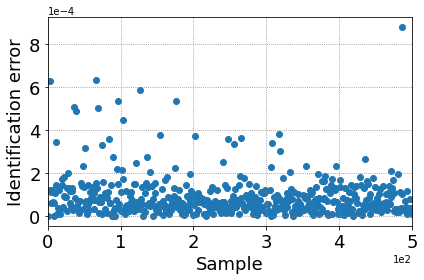

In [55]:
font_size = 18
rms = (np.mean((x_next_pred-x_next_rand)**2,axis=1))

idx_sample = np.linspace(1,num_data,num_data)

fig = plt.figure()

plt.scatter(idx_sample,rms)

plt.xlabel('Sample',fontsize = font_size)
plt.ylabel('Identification error',fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.xlim(0, num_data)
plt.grid(color='gray', linestyle=':')
plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0)) 
##

plt.tight_layout()
plt.savefig('./figures/model_error_nl.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')


In [56]:
torch.save(model.state_dict(), "model.pkl")